<a href="https://colab.research.google.com/github/SiLiKhon/RICH_GAN_misc/blob/master/RICH_Data_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RICH Data Overview

## Get the data

The training sample is shared [here](https://cernbox.cern.ch/index.php/s/RkZoMRBofrhqzZm).

These are simulated detector responses for 6 particle types (below are per-file links to the same files as above):



*   electrons https://cernbox.cern.ch/index.php/s/q5ZwDYfvOXJmnBR
*   kaons https://cernbox.cern.ch/index.php/s/nfBRDGCagdgor3q
*   muons https://cernbox.cern.ch/index.php/s/jfw0Nhyw8gYNBhk
*   pions https://cernbox.cern.ch/index.php/s/dyZJGMZuVRW0Kgg
*   protons https://cernbox.cern.ch/index.php/s/SQ6G6dmLOLTvMuz
*   ghosts https://cernbox.cern.ch/index.php/s/9Ui4xKerEDdw7Fv (these are 'fake' tracks - i.e. random tracker hits that look like a track from a real particle)



In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from itertools import combinations, product
from functools import reduce

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
data_dir = Path('./data_csv')

data = {}
for file in data_dir.iterdir():
    name = file.stem.split('_')[1]
    data[name]  = pd.read_csv(file.as_posix())

In [3]:
print(f'Particle types:\n{list(data.keys())}')
cols = list(data.values())[0].columns.tolist()
print(f'Features:\n{cols}')

Particle types:
['muon', 'ghost', 'kaon', 'proton', 'pion', 'electron']
Features:
['TrackPt', 'TrackP', 'NumLongTracks', 'MCParticleType', 'RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe', 'TrackEta']


Input variables are:
*   `TrackP` – full momentum of the particle
*   `TrackPt` – length of the momentum projection to the XY plane
*   `TrackEta` – track [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity)
*   `NumLongTracks` – number of reconstructed tracks in current event

Please note that among P, Pt and ETA there are only **two** independant variables. 


The variables to predict are:

*   `RichDLLbt`
*   `RichDLLk`
*   `RichDLLmu`
*   `RichDLLp`
*   `RichDLLe`


There's also one additional variable:

*   `MCParticleType` – particle [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)




In [4]:
x_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

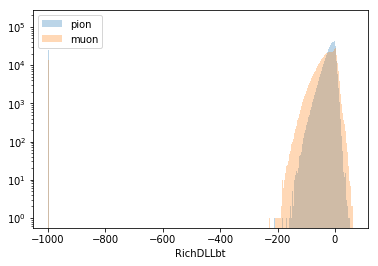

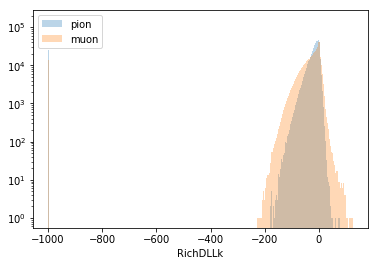

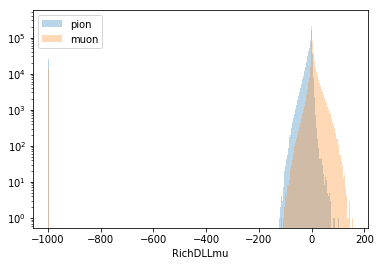

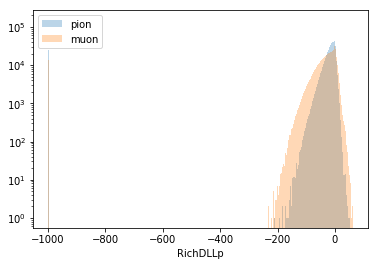

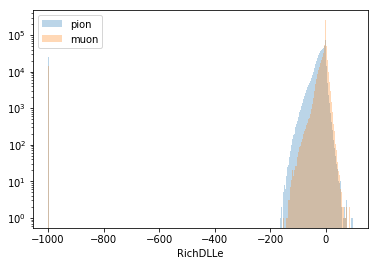

In [5]:
for col in y_cols:
    left = reduce(min,[data[p][col].min() for p in ('pion','muon')])
    right = reduce(max,[data[p][col].max() for p in ('pion','muon')])
    bins = np.linspace(
        start=left, 
        stop =right, 
        num=601
    )
    for p in ('pion','muon'):
        plt.hist(data[p][col], bins=bins, label=p,alpha=0.3)
    plt.yscale('log')
    plt.legend()
    plt.xlabel(col)
    plt.show()

One can see there's a peak of outliers at the left handside of the plot. Let's not bother about it so far.

In [6]:
def not_outliers(df,m):
    left = (df >= df.median() - df.std()*m).all(axis=1)
    right = (df <= df.median() + df.std()*m).all(axis=1)
    return left&right

In [7]:
masks = {p:not_outliers(data[p],2) for p in data}

### Feature histograms for all particle types

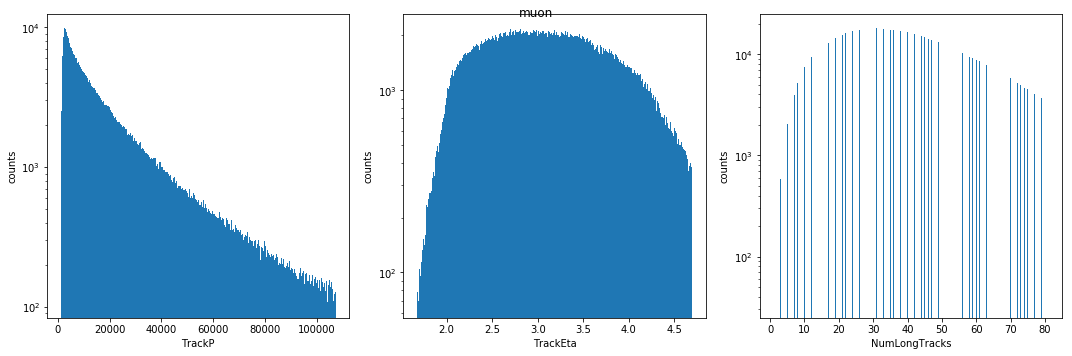

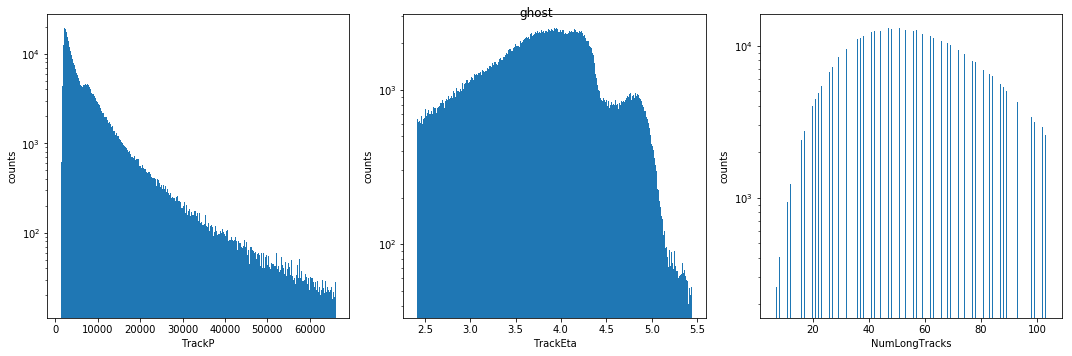

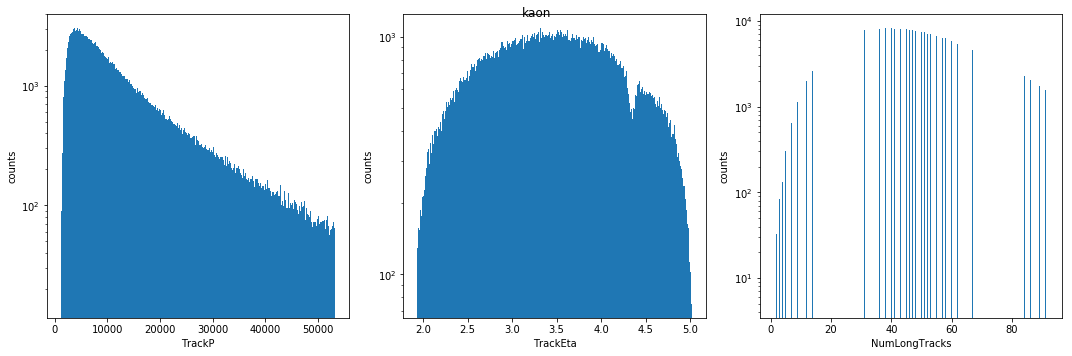

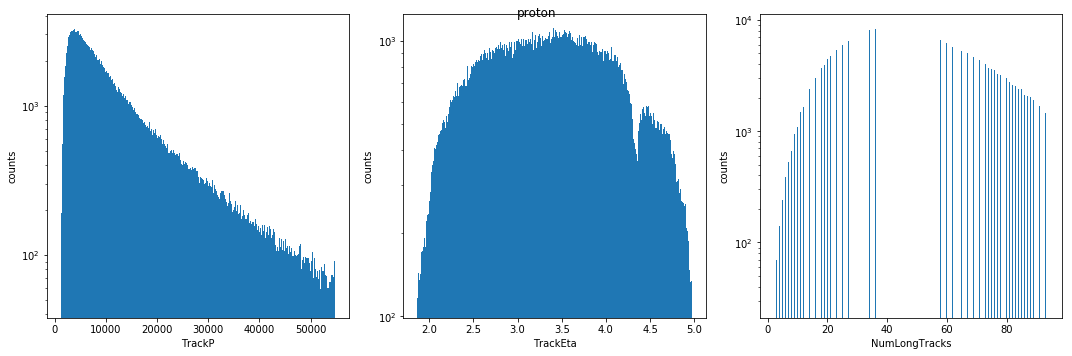

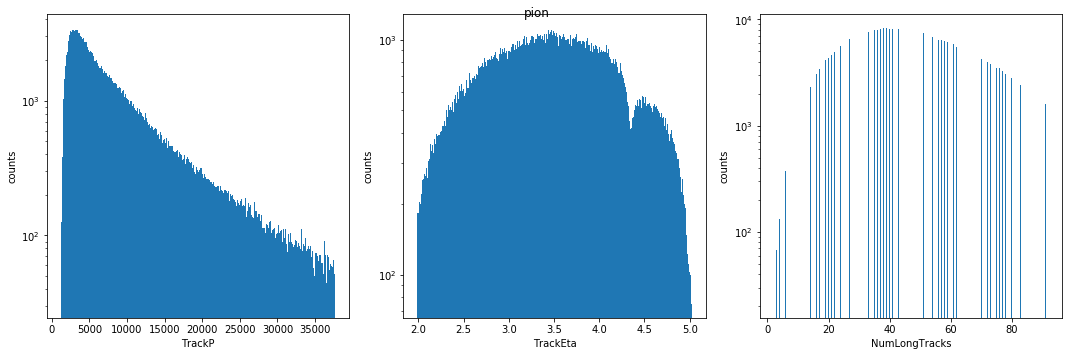

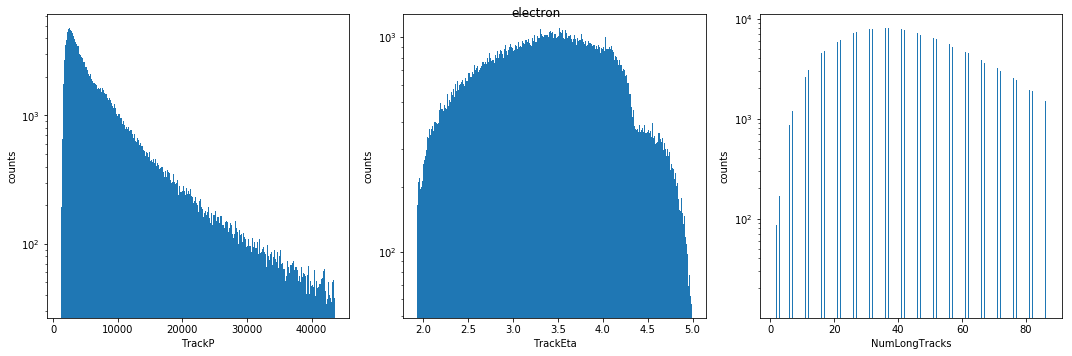

In [8]:
for i, p in enumerate(data):
    fig, axes = plt.subplots(nrows=1, ncols=len(x_cols), figsize=(15,5))
    for j, col in enumerate(x_cols):

        _, _, img = axes[j].hist(data[p][masks[p]][col],bins=601)
        axes[j].set_xlabel(col)
        axes[j].set_ylabel('counts')
        axes[j].set_yscale('log')
    fig.tight_layout()
    fig.suptitle(p)

### DLL histogram for all particle types

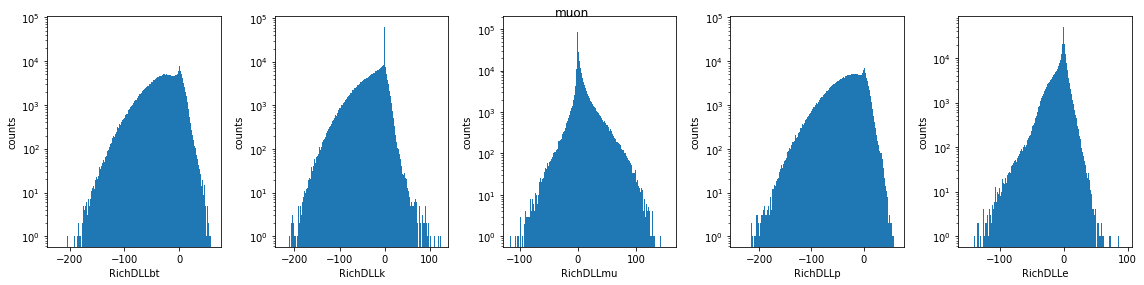

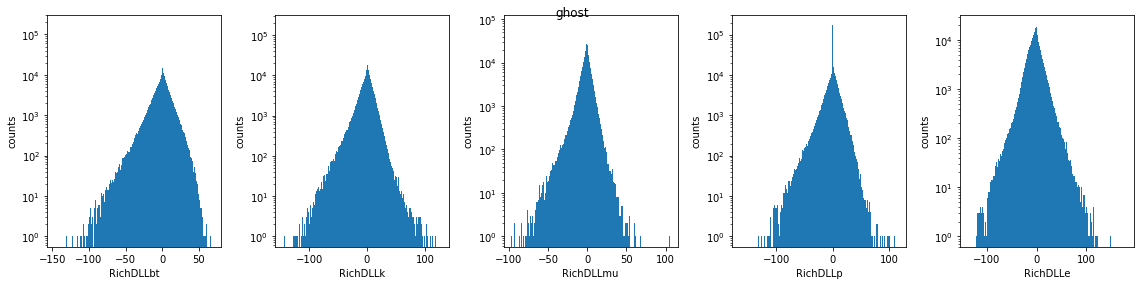

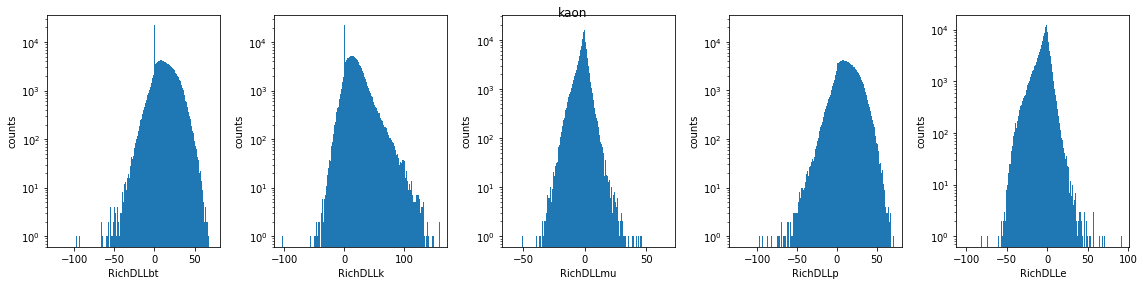

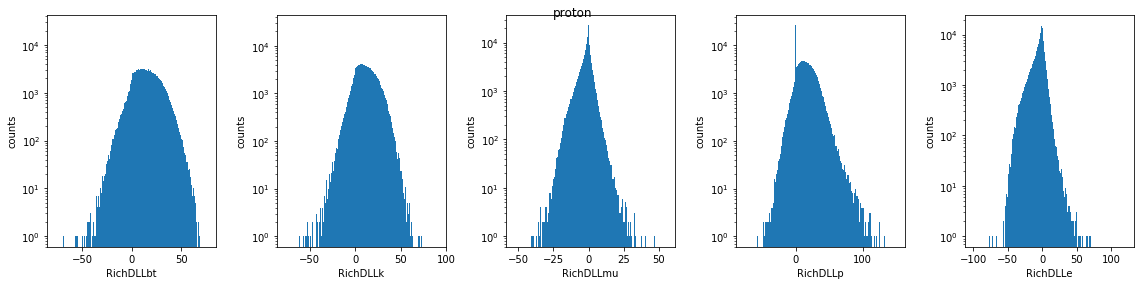

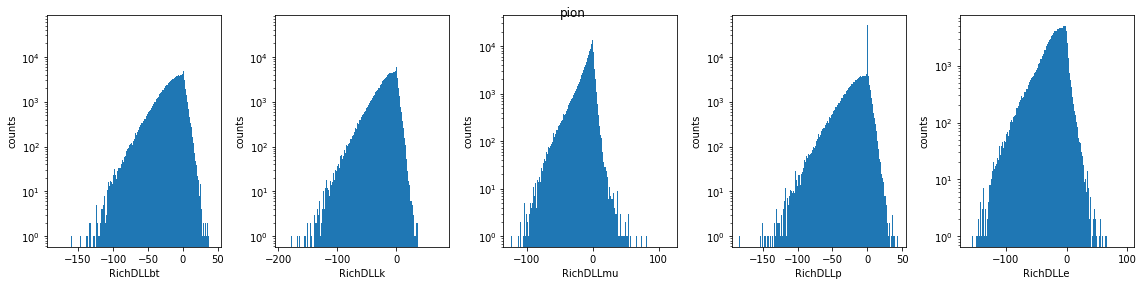

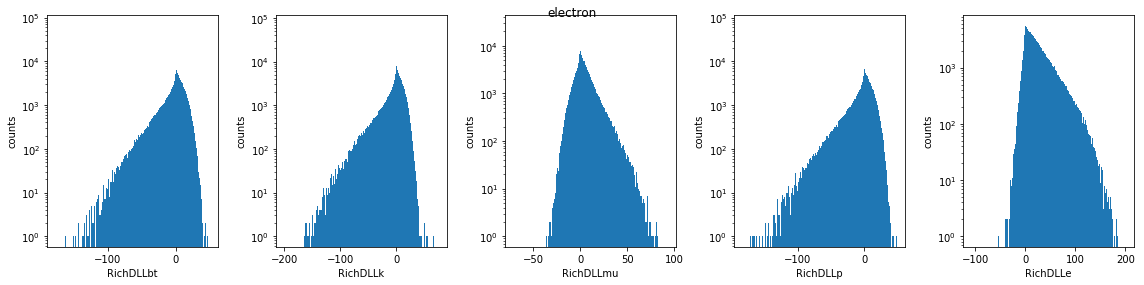

In [9]:
for i, p in enumerate(data):
    fig, axes = plt.subplots(nrows=1, ncols=len(y_cols), figsize=(16,4))
    for j, col in enumerate(y_cols):

        _, _, img = axes[j].hist(data[p][masks[p]][col],bins=601)
        axes[j].set_xlabel(col)
        axes[j].set_ylabel('counts')
        
        axes[j].set_yscale('log')
    fig.tight_layout()
    fig.suptitle(p)
    print()

In [10]:
def hist2d(data,col1,col2,bins_x, bins_y):
    
    fig, axes = plt.subplots(
                                    nrows= 2,
                                    ncols= int(len(data)/2),
                                    figsize=(15, 6)
                                )
    
    for i, p in enumerate(data):
        _, _, _, img = \
            axes[i % 2][i//2].hist2d(
                x=data[p][col1],
                y=data[p][col2],
                bins=(bins_x, bins_y),
                cmap='inferno',
                norm=colors.LogNorm()
            )
        axes[i % 2][i//2].set_xlabel(col1)
        axes[i % 2][i//2].set_ylabel(col2)
        axes[i % 2][i//2].set_title(p)
        plt.colorbar(img, ax=axes[i % 2][i//2])
        
    fig.suptitle(f'{x}x{y}')
    fig.tight_layout();

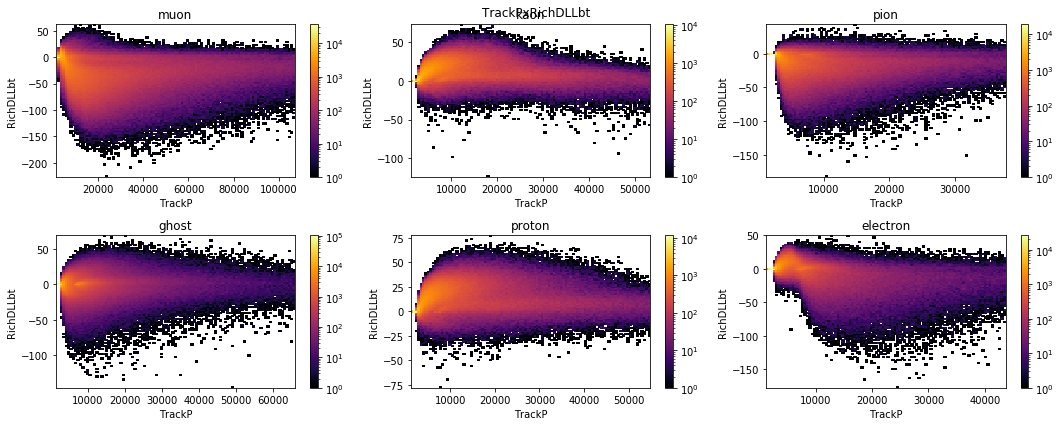

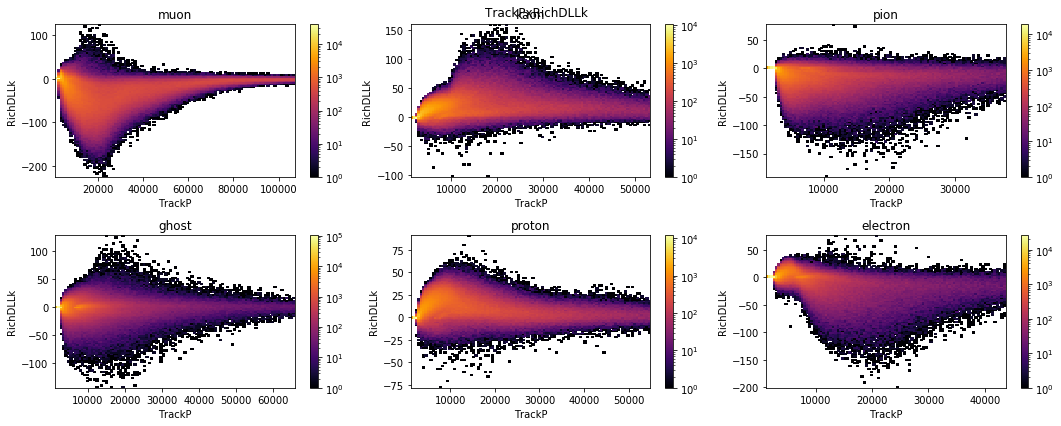

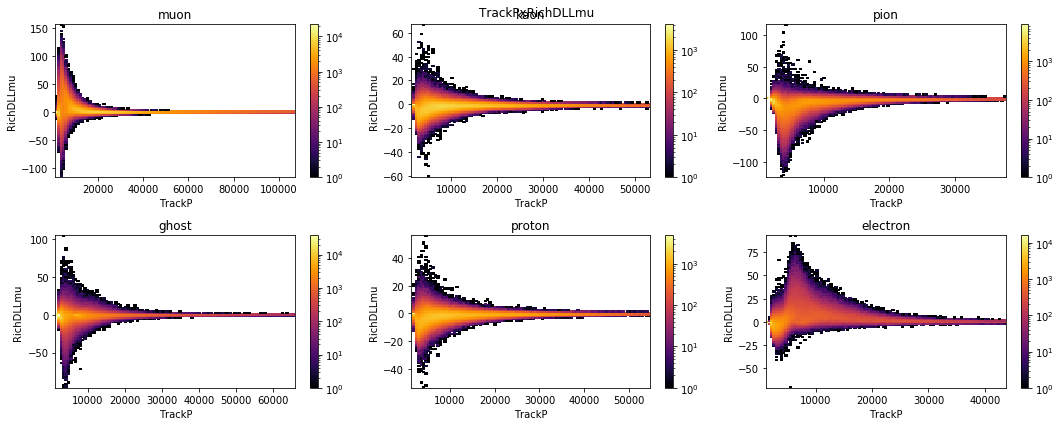

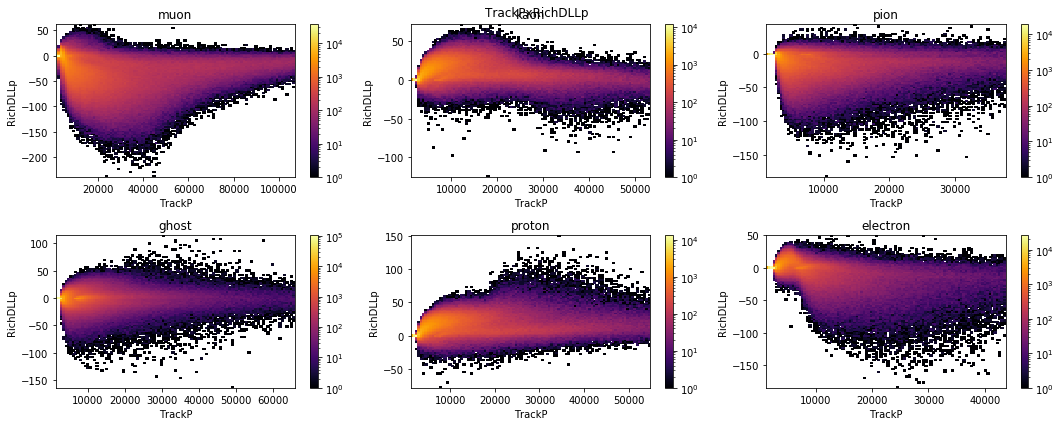

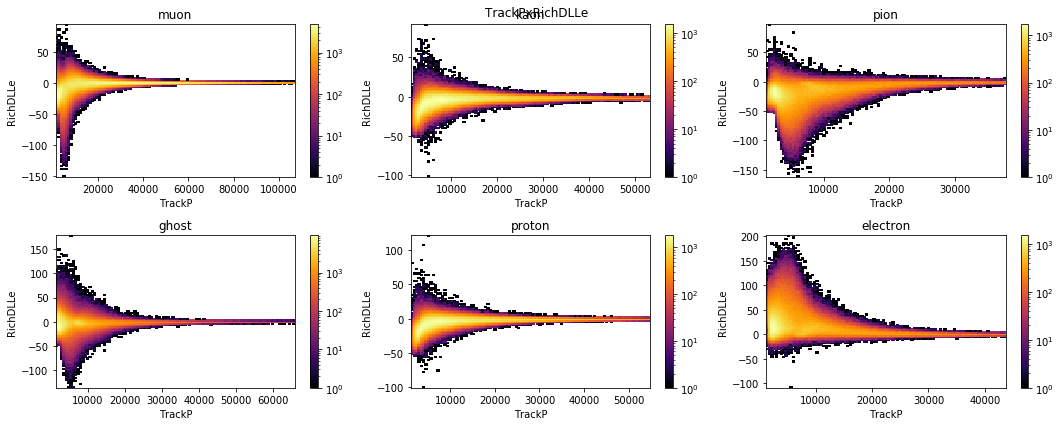

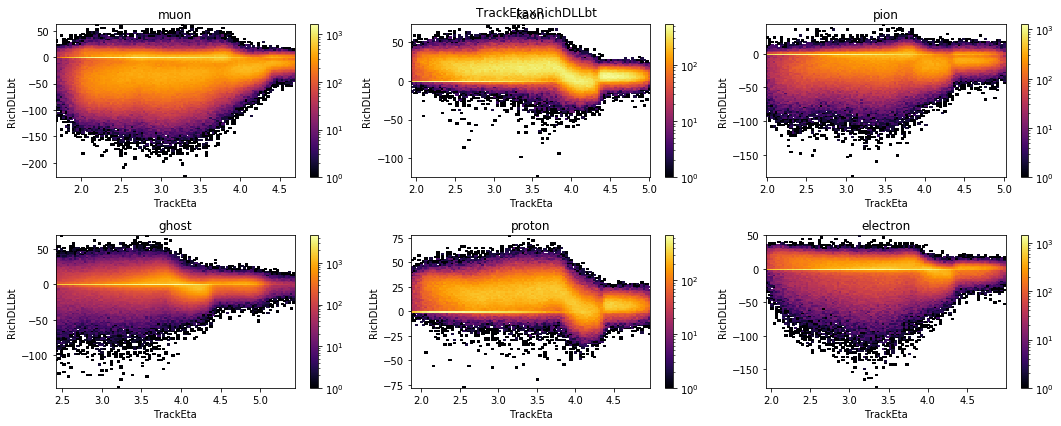

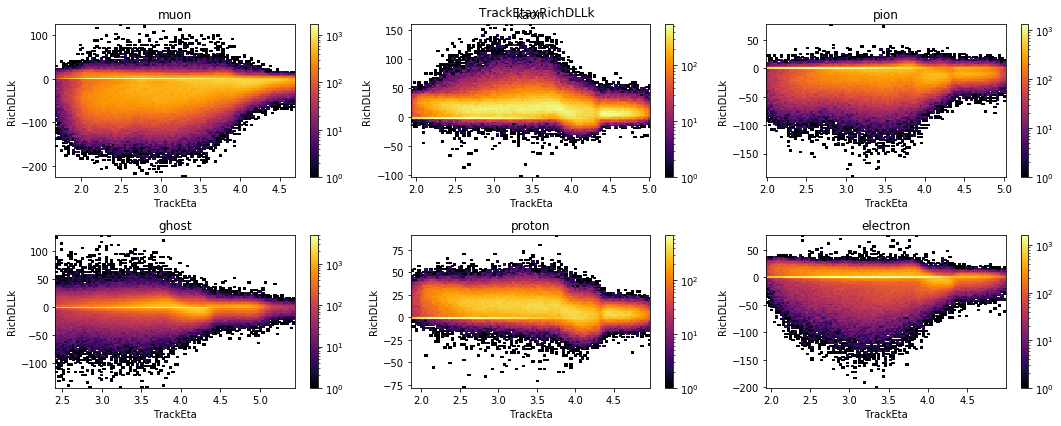

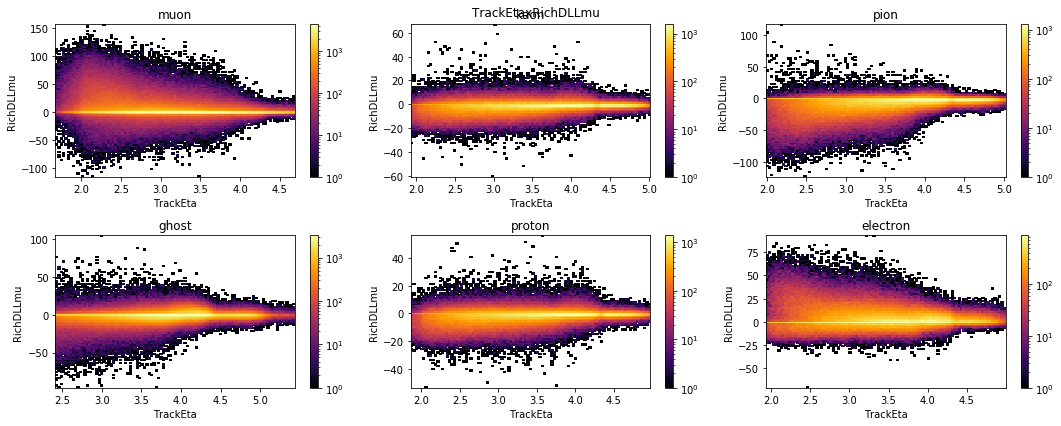

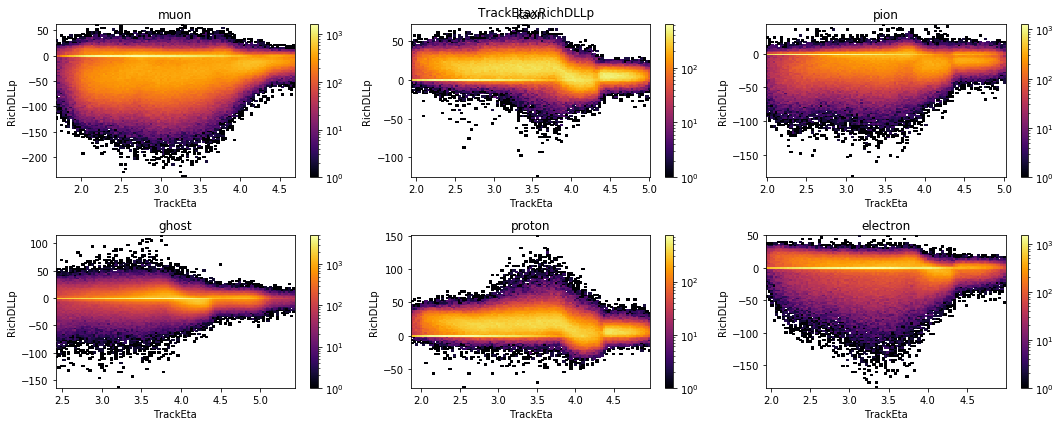

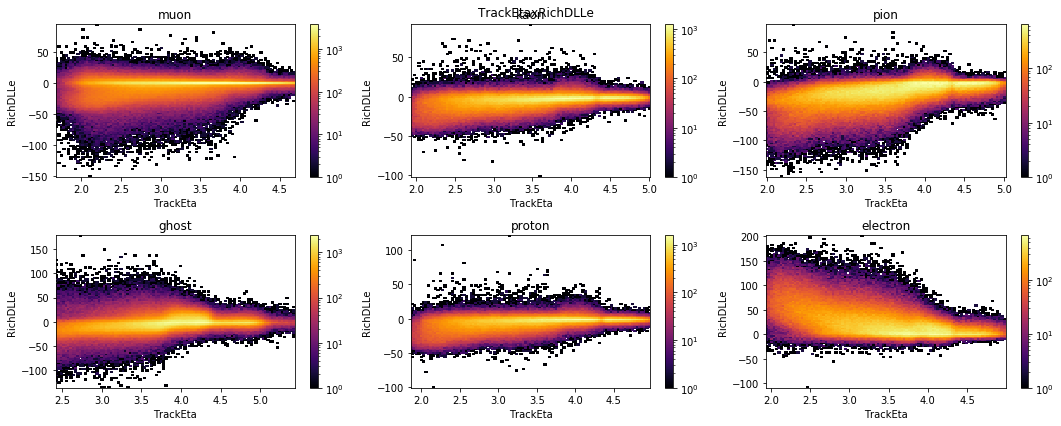

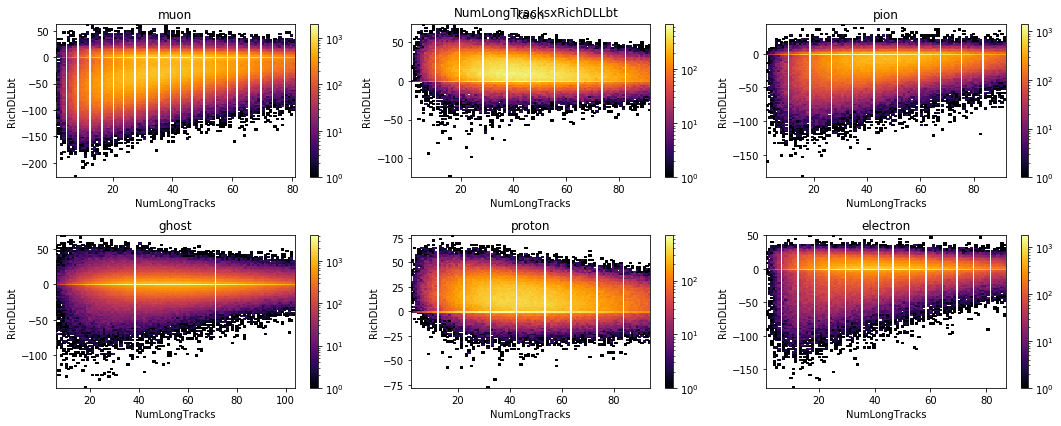

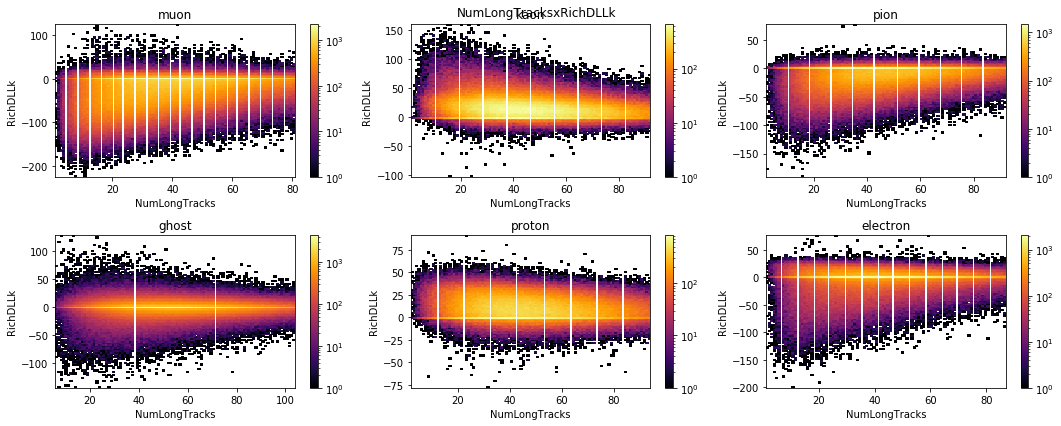

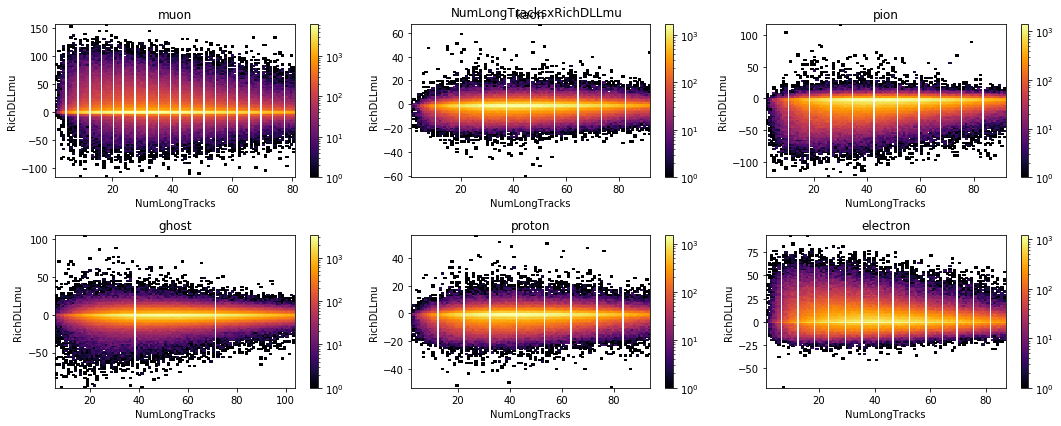

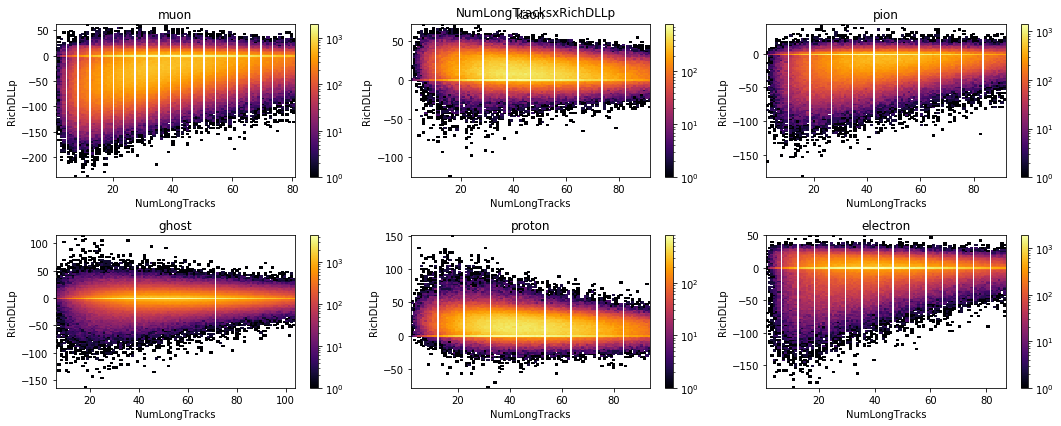

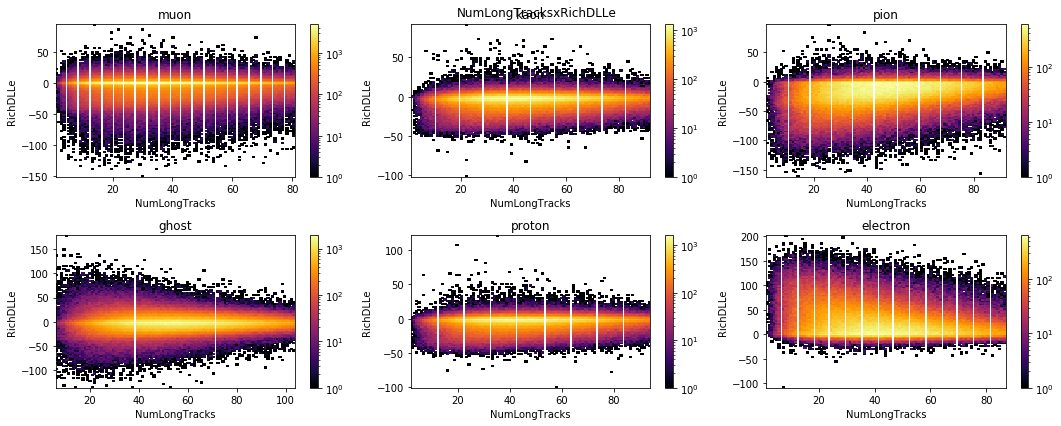

In [11]:
for x, y in product(x_cols,y_cols):
    
    hist2d({p:data[p][masks[p]] for p in data},x,y,101,101)
    print()

# The simplest model possible

In [12]:
class Model:
    def train(self, X, Y):
        self.means = {}
        self.stds = {}
        for col in Y.columns:
            self.means[col] = np.mean(Y[col])
            self.stds [col] = np.std (Y[col])

    def predict(self, X):
        prediction = pd.DataFrame()
        for col in self.means.keys():
            prediction[col] = np.random.normal(
                                loc=self.means[col],
                                scale=self.stds[col],
                                size=len(X)
                            )
        return prediction

In [13]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

In [14]:
def score_func(sample1, sample2, n_slices=100):
    score = 0
    cols = x_cols + y_cols
    w_normal = np.random.normal(size=(n_slices, len(cols)))
    sample1 = sample1.copy()[cols].values
    sample2 = sample2.copy()[cols].values
    for k in range(n_slices):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * sample1, axis=1), 
                        np.sum(w_normal[k] * sample2, axis=1)
                    )[0]
                   )
    return score

In [15]:
kf = KFold(n_splits=5)

model_scores = {p:[] for p in data}
best_scores  = {p:[] for p in data}

for p in data:
    for train_index, test_index in kf.split(data[p][x_cols]):
        X_train = data[p][x_cols].iloc[train_index]
        Y_train = data[p][y_cols].iloc[train_index]
        X_test  = data[p][x_cols].iloc[test_index]
        Y_test  = data[p][y_cols].iloc[test_index]
      
        model = Model()
        model.train(X_train[masks[p][train_index]], Y_train[masks[p][train_index]])
        Y_pred = model.predict(X_test)
        
        sample_pred = pd.concat((X_test,Y_pred),axis=1)
        sample_train = pd.concat((X_train,Y_train),axis=1)
        sample_test = pd.concat((X_test,Y_test), axis=1)
        model_scores[p].append(score_func(sample_pred, sample_test))
        best_scores[p].append(score_func(sample_train, sample_test))

In [16]:
for p in best_scores:
    print(p)
    print(best_scores[p],'\n')

muon
[0.013064287709811495, 0.003318275470905685, 0.01782693071633662, 0.004613377964527543, 0.008825439574450589] 

ghost
[0.0036412682063410307, 0.0033662668313341193, 0.0028925144625723265, 0.004031270156350852, 0.004658773293866436] 

kaon
[0.006406030962646803, 0.0027579057862189282, 0.009593984336944417, 0.0031874688274192153, 0.0040352810293145525] 

proton
[0.002604386130512615, 0.0030472990445190584, 0.0031143994118960627, 0.0030252726592228663, 0.003724011122480664] 

pion
[0.003109719416553358, 0.0031779466605007523, 0.003583233113515494, 0.0025346716848643203, 0.0034315284076982255] 

electron
[0.007173034192066274, 0.0019926704515962346, 0.006334444792239213, 0.003712962086512117, 0.0018394553527232294] 



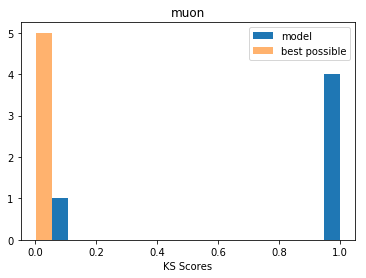

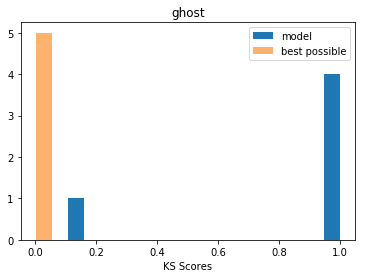

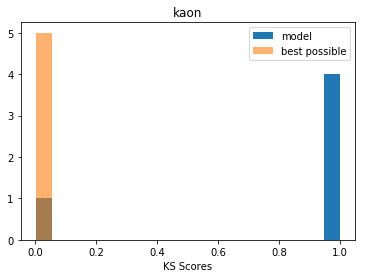

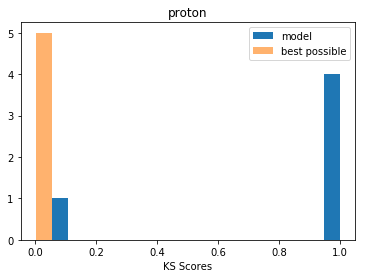

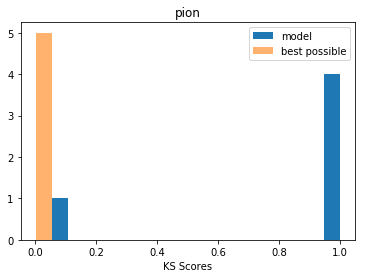

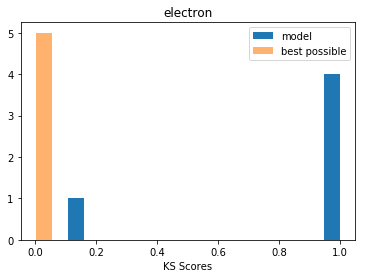

In [17]:
for p in best_scores:
    bins = np.linspace(
                start=min(model_scores[p] + best_scores[p]), 
                stop =max(model_scores[p] + best_scores[p]), 
                num=20
            )
    
    plt.hist(model_scores[p], bins=bins, label='model')
    plt.hist(best_scores[p] , bins=bins, label='best possible', alpha=0.6)
    plt.legend()
    plt.xlabel('KS Scores')
    plt.title(p)
    plt.show();

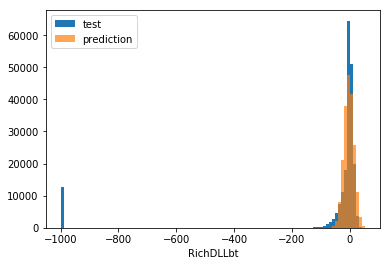

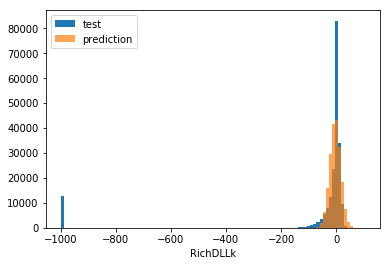

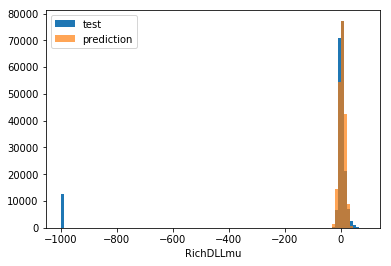

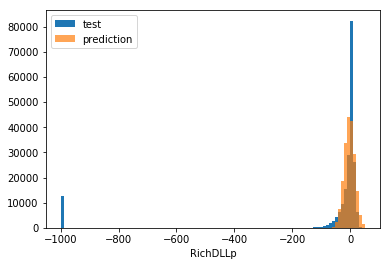

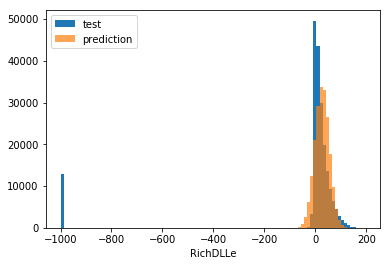

In [18]:
for col in Y_pred.columns:
    _, bins, _ = plt.hist(Y_test[col], bins=100 , label='test'      )
    _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
    plt.legend()
    plt.xlabel(col)
    plt.show();

##  Conditional Gaussian Model

$P(Y|X)\sim N(\mu(X),\Sigma(X))$

First we go for model with $Cov(y_i,y_j)=0, i\not =j$, namely distinct model for each component of $Y$. Also for simplicity we condition on only one component of $X$


In [19]:

class Model:
    def __init__(self,cond, n_intervals=4):
        self.n_intervals = n_intervals
        self.cond = cond
        
    def train(self, X, Y):
        
        bounds = [np.quantile(X[cond], i/self.n_intervals) for i in range(self.n_intervals+1)]
        lefts = bounds[:-1]
        rights = bounds[1
                        
        self.means = {}
        self.stds = {}
                        
        for i in range(self.n_intervals):
            point = (lefts[i]+rights[i])/2 
            self.means[point] = {}
            for col in Y.columns:
                self.means[point][col] = Y(X[self.cond] > lefts[i]) & (X[self.cond] <= rights[i])[col].mean()
                self.stds[point][col] = Y(X[self.cond] > lefts[i]) & (X[self.cond] <= rights[i])[col].std()

    def predict(self, X):
        prediction = pd.DataFrame()
        for col in self.means.keys():
            prediction[col] = np.random.normal(
                                loc=self.means[col],
                                scale=self.stds[col],
                                size=len(X)
                            )
        return prediction

SyntaxError: invalid syntax (<ipython-input-19-ceb0f5060df0>, line 13)